In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files,drive
import torch
from torchvision import models,datasets,transforms
from PIL import Image
import torch.nn.functional as F
from torch import nn,optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time
%matplotlib inline


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
p='/content/drive/"My Drive"/"Emoji dataset"'
!ls {p}

'Call me'      'Middle finger'	'Sign of horrs'  'Vulcan sulate'
'Forced hand'  'Raised hand'	'Victory hand'


In [0]:
train_transforms = transforms.Compose([transforms.Resize(200),
                                        transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485,0.456,0.406),(0.299,0.224,0.225))])

test_transforms = transforms.Compose([transforms.Resize(200),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406),(0.299,0.224,0.225))])

In [0]:
image_datasets = datasets.ImageFolder(root= "/content/drive/My Drive/Emoji dataset/",transform=train_transforms)

In [0]:
full_train_size = int(0.92 * len(image_datasets))
train_size=int(0.92*full_train_size)
valid_size=full_train_size-train_size
test_size = len(image_datasets) - full_train_size

train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size,valid_size, test_size])

In [7]:
print("Number of Examples Of  Trainning Dataset ",len(train_dataset))
print("Number of Examples Of  Validation Dataset ",len(valid_dataset))
print("Number of Examples Of  Testing Dataset ",len(test_dataset))


Number of Examples Of  Trainning Dataset  938
Number of Examples Of  Validation Dataset  82
Number of Examples Of  Testing Dataset  89


In [0]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader=torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=True)
testloader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [0]:
dataiter = iter(trainloader)
images,labels= next(dataiter)

In [0]:
def im_convert(tensor):
    image=tensor.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image

In [0]:
cat={0:"Call Me",1:"Forced Hand",2:"Middle Finger",3:"Raised Hand",4:"Sign of Horrs",5:"Victory Hand",6:"Vulcan Sulate"}

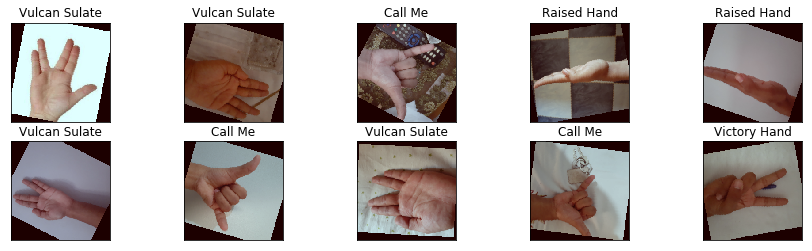

In [12]:
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    plt.title(cat[labels[idx].item()])

In [13]:
model=models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98774713.73it/s]


In [14]:
for param in model.parameters():
    param.requires_grad = False
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [0]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device);

In [17]:
epochs=25
valid_loss_min = np.Inf
validlosses,trainlosses=[],[]


for epoch in range(epochs):
  print("Epoch: {}/{} ........".format(epoch+1, epochs))
  
  start = time.time()
 
  
  steps=0
  running_loss=0.0
  accuracy_train=0.0
  
  steps2=0
  valid_loss = 0
  accuracy_valid = 0
    
  model.train()
  
  
  for inputs, labels in trainloader:
    
    steps += 1
    # Move input and label tensors to the default device
    inputs, labels = inputs.to(device), labels.to(device)
        
    optimizer.zero_grad()
        
    logps = model(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()*inputs.size(0)
    
    ret, predictions = torch.max(logps.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    # Convert correct_counts to float and then compute the mean
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
    # Compute total accuracy in the whole batch and add to train_acc
    accuracy_train += acc.item() * inputs.size(0)
    print("Training Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(steps, loss.item(), acc.item()))
    
  else:
   
    with torch.no_grad():
      model.eval()
      for inputs, labels in validloader:
        steps2+=1
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
                    
        valid_loss += loss.item()
        # Calculate validation accuracy
        ret, predictions = torch.max(logps.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
        # Compute total accuracy in the whole batch and add to valid_acc
        accuracy_valid += acc.item() * inputs.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(steps2, loss.item(), acc.item()))
    
    
  # Find average training loss and training accuracy
  avg_train_loss = running_loss/train_size 
  avg_train_acc = accuracy_train/float(train_size)
 
  # Find average training loss and training accuracy
  avg_valid_loss = valid_loss/valid_size 
  avg_valid_acc = accuracy_valid/float(valid_size)


    
  trainlosses.append(avg_train_loss)
  validlosses.append(avg_valid_loss)
  stop = time.time()

  end = time.time()
 
  print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, end-start))
    
    
  if avg_valid_loss <= valid_loss_min:
      
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          avg_valid_loss))
      torch.save(model.state_dict(), 'model_emoji.pt')
      valid_loss_min = avg_valid_loss


Epoch: 1/25 ........
Training Batch number: 001, Training: Loss: 1.9654, Accuracy: 0.0938
Training Batch number: 002, Training: Loss: 2.2522, Accuracy: 0.0625
Training Batch number: 003, Training: Loss: 1.9247, Accuracy: 0.1250
Training Batch number: 004, Training: Loss: 1.9855, Accuracy: 0.0938
Training Batch number: 005, Training: Loss: 2.0884, Accuracy: 0.1250
Training Batch number: 006, Training: Loss: 1.9583, Accuracy: 0.1562
Training Batch number: 007, Training: Loss: 2.0246, Accuracy: 0.2812
Training Batch number: 008, Training: Loss: 2.0979, Accuracy: 0.3125
Training Batch number: 009, Training: Loss: 1.9171, Accuracy: 0.1875
Training Batch number: 010, Training: Loss: 1.8019, Accuracy: 0.3438
Training Batch number: 011, Training: Loss: 1.9309, Accuracy: 0.0938
Training Batch number: 012, Training: Loss: 1.7050, Accuracy: 0.4062
Training Batch number: 013, Training: Loss: 1.9218, Accuracy: 0.3438
Training Batch number: 014, Training: Loss: 1.8874, Accuracy: 0.1875
Training Batc

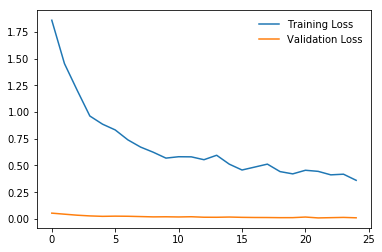

In [18]:
plt.plot(trainlosses,label='Training Loss')
plt.plot(validlosses,label='Validation Loss')
plt.legend(frameon=False)

In [19]:
model.load_state_dict(torch.load('model_emoji.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [20]:
train_on_GPU=True
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_GPU else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            cat[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.349559

Test Accuracy of Call Me: 91% (11/12)
Test Accuracy of Forced Hand: 100% ( 9/ 9)
Test Accuracy of Middle Finger: 85% ( 6/ 7)
Test Accuracy of Raised Hand: 68% (11/16)
Test Accuracy of Sign of Horrs: 80% ( 8/10)
Test Accuracy of Victory Hand: 100% (15/15)
Test Accuracy of Vulcan Sulate: 100% (20/20)

Test Accuracy (Overall): 89% (80/89)


In [0]:
img=Image.open("/content/drive/My Drive/Test/A.jpg")

In [0]:
img=train_transforms(img)

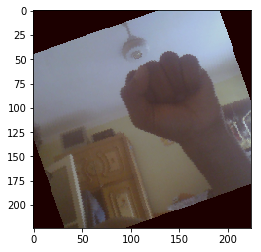

In [50]:
plt.imshow(im_convert(img))

In [51]:
img=img.view(1, 3, 224, 224).cuda()
with torch.no_grad():
  
  model.eval()
  # Model outputs log probabilities
  out = model(img)
  ps = torch.exp(out)
  topk, topclass = ps.topk(1, dim=1)
  print("Output class :  ", cat[topclass.cpu().numpy()[0][0]])

Output class :   Forced Hand
